In [1]:
from utils import *

train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## Perform Sanity Checks

### Check for missing values in the datasets

Check if the train dataset contains any missing values in its columns.

In [2]:
check_missing_columns(train)

id                False
industry           True
state             False
request_date      False
term              False
employee_count    False
business_new      False
business_type     False
location          False
other_loans       False
loan_amount       False
insured_amount    False
default_status    False
dtype: bool

Industry column in train dataset contains missing values. Let's dive deeper to see how many records contains missing industry.

In [3]:
train[train.industry.isna()]

,id,industry,state,request_date,term,employee_count,business_new,business_type,location,other_loans,loan_amount,insured_amount,default_status
1946,3771775001,NaN,NH,20-Nov-09,12,1,New,0,Rural,N,$100.00,"$75,000.00",0


1 record contains missing industry value. Let's drop that record.

In [4]:
train = train.dropna()
train.shape

(2401, 13)


Check if the test dataset contains any missing values in its columns.

In [5]:
check_missing_columns(test)

id                False
industry          False
state             False
request_date      False
term              False
employee_count    False
business_new      False
business_type     False
location          False
other_loans       False
loan_amount       False
insured_amount    False
dtype: bool

Test dataset does not contain any missing values.

### Check if the test dataset contains categorical values that are not present in train dataset.

In [6]:
columns_missing_categories = check_categories(
    test, train, 
    categorical_fields = ['industry', 'state', 'business_new', 'business_type', 'location', 'other_loans']
)
columns_missing_categories

Checking categorical column: industry
Unique categories in train: {'Energy', 'Finance', 'Agriculture', 'Healthcare', 'Transportation', 'Others', 'Hotel', 'Trading', 'Entertainment', 'Engineering', 'Manufacturing', 'Consulting', 'Education', 'Administration', 'Real Estate', 'Construction'}
Unique categories in test: {'Energy', 'Finance', 'Agriculture', 'Healthcare', 'Administration', 'Hotel', 'Others', 'Trading', 'Entertainment', 'Engineering', 'Consulting', 'Manufacturing', 'Education', 'Construction', 'Real Estate', 'Transportation'}
Categories in test but not train: set()

Checking categorical column: state
Unique categories in train: {'WY', 'IN', 'NJ', 'SC', 'DE', 'AZ', 'MO', 'VA', 'LA', 'MD', 'VT', 'RI', 'IL', 'OR', 'CO', 'NH', 'CA', 'ID', 'NC', 'AK', 'CT', 'MT', 'HI', 'MA', 'WI', 'ND', 'WA', 'NV', 'AR', 'SD', 'NE', 'KS', 'PA', 'NM', 'TX', 'ME', 'FL', 'WV', 'NY', 'OK', 'MS', 'IA', 'UT', 'TN', 'MI', 'MN', 'GA', 'KY', 'OH', 'AL'}
Unique categories in test: {'IN', 'NJ', 'SC', 'DE', 'M

[]

All of the categorical values present in test dataset can also be found in the train dataset. Additionally, it could be observed that the location field only has one unique value, 'Rural' in both the train and test datasets. Since every record has the same location 'Rural', the location field would not have any discriminative power over default_status. Hence, let's drop the location field from the potential list of features to include in the model.

In [7]:
train = train.drop(columns = ['location'])
test = test.drop(columns = ['location'])

## Perform Data Preprocessing

### Preprocessing Steps:

1) Cast request_date to a datetime object.
2) Cast loan_amount and insured_amount to float.

In [8]:
train = convert_to_datetime(train)
train = convert_amt_cols_to_float(train, amt_cols = ['loan_amount', 'insured_amount'])
train.head(2)

loan_amount
<class 'str'>    2401
Name: count, dtype: int64
count    2.401000e+03
mean     2.045728e+05
std      3.643876e+05
min      3.000000e+03
25%      2.500000e+04
50%      5.000000e+04
75%      2.169900e+05
max      4.000000e+06
Name: loan_amount, dtype: float64

insured_amount
<class 'str'>    2401
Name: count, dtype: int64
count    2.401000e+03
mean     1.550500e+05
std      3.114833e+05
min      1.700000e+03
25%      1.275000e+04
50%      3.500000e+04
75%      1.250000e+05
max      4.000000e+06
Name: insured_amount, dtype: float64



,id,industry,state,request_date,term,employee_count,business_new,business_type,other_loans,loan_amount,insured_amount,default_status
0,4050975007,Others,VA,2010-04-27,34,4,New,0,N,35000.0,35000.0,1
1,3735095001,Manufacturing,CA,2009-11-05,107,1,New,0,N,15000.0,13500.0,1


In [9]:
test = convert_to_datetime(test)
test = convert_amt_cols_to_float(test, amt_cols = ['loan_amount', 'insured_amount'])
test.head(2)

loan_amount
<class 'str'>    601
Name: count, dtype: int64
count    6.010000e+02
mean     1.885422e+05
std      3.085025e+05
min      2.000000e+03
25%      2.500000e+04
50%      5.194000e+04
75%      2.180000e+05
max      2.000000e+06
Name: loan_amount, dtype: float64

insured_amount
<class 'str'>    601
Name: count, dtype: int64
count    6.010000e+02
mean     1.469891e+05
std      2.720625e+05
min      1.000000e+03
25%      1.275000e+04
50%      3.500000e+04
75%      1.275000e+05
max      1.500000e+06
Name: insured_amount, dtype: float64



,id,industry,state,request_date,term,employee_count,business_new,business_type,other_loans,loan_amount,insured_amount
0,3999155010,Hotel,CA,2010-03-26,91,1,Existing,1,N,270000.0,243000.0
1,4035035009,Hotel,WA,2010-04-19,124,0,Existing,0,N,443574.0,432000.0


## Perform Feature Engineering 

### Features to create

1. loan_insured_amount_diff: Difference between loan_amount and insured_amount (i.e. loan_amount - insured_amount)
2. insured_loan_ratio: Ratio between insured_amount and loan_amount (i.e. insured_amount / loan_amount)

In [10]:
train = create_loan_insured_features(train)
train.head(2)

,id,industry,state,request_date,term,employee_count,business_new,business_type,other_loans,loan_amount,insured_amount,default_status,loan_insured_amount_diff,insured_loan_ratio
0,4050975007,Others,VA,2010-04-27,34,4,New,0,N,35000.0,35000.0,1,0.0,1.0
1,3735095001,Manufacturing,CA,2009-11-05,107,1,New,0,N,15000.0,13500.0,1,1500.0,0.9


In [11]:
test = create_loan_insured_features(test)
test.head(2)

,id,industry,state,request_date,term,employee_count,business_new,business_type,other_loans,loan_amount,insured_amount,loan_insured_amount_diff,insured_loan_ratio
0,3999155010,Hotel,CA,2010-03-26,91,1,Existing,1,N,270000.0,243000.0,27000.0,0.900000
1,4035035009,Hotel,WA,2010-04-19,124,0,Existing,0,N,443574.0,432000.0,11574.0,0.973907


## Perform Exploratory Data Analysis

### Analyse the request date distributions in train and test datasets.

In [12]:
train.request_date.describe()

count                             2401
mean     2010-03-15 00:34:47.130362368
min                2009-10-01 00:00:00
25%                2009-12-14 00:00:00
50%                2010-03-11 00:00:00
75%                2010-06-02 00:00:00
max                2010-09-30 00:00:00
Name: request_date, dtype: object

In [13]:
test.request_date.describe()

count                              601
mean     2010-03-11 00:38:20.166389248
min                2009-10-01 00:00:00
25%                2009-12-09 00:00:00
50%                2010-03-04 00:00:00
75%                2010-06-07 00:00:00
max                2010-09-30 00:00:00
Name: request_date, dtype: object

The request_date range for both the train and test datasets are the same, starting from 2009-10-01 and ending on 2010-09-30. request_date wise, it seems that both the train and test datasets were drawn from the same distribution.

### Analyse the distribution of target variable, default_status

In [14]:
plot_categories_distribution(train, 'default_status', width = 800, height = 400)

It could be observed that the train dataset is imbalanced in terms of the target variable, default status. The number of companies that do not default (i.e. default_status = 0) is ~2x of the number of companies that default (i.e. default_status = 1). In such a case, accuracy might not be the most appropriate performance metric to use, as it is bias towards the majority class (i.e. default_status = 0). Instead f1 might be a more appropriate performance metric to use, as it is the harmonic mean of precision and recall, and hence unbiased towards either of the classes.

### Analyse the probability of default given a categorical value

In [15]:
plot_category_default_distribution(train, 'industry')

The plot above suggests that there is a strong correlation between the industry and the default status. Some industries are significantly more prone to default as compared to others.

For example, it could be observed that the top 3 industries most likely to default are Construction, Hotel and Engineering, each having more than or equal to 0.375 probability of default. On the other hand, the Energy industry is the least likely to default, with only a 0.11 probability of default.

In [16]:
plot_category_default_distribution(train, 'state')

The plot above suggests that there is a strong correlation between the state and the default status. Some states are significantly more prone to default as compared to others.

For example, it could be observed that companies in the states DE, AZ, GA and AR are likely to default more than 50% of the time (i.e. their probability of default is greater than 0.5), whereas companies in the state CT are likely to default only 11% of the time (i.e. their probability of default = 0.11)

In [17]:
plot_category_default_distribution(train, 'business_new', height = 400)

The plot above suggests that there is no strong correlation between business_new and the default status, given that the probability of default for New and Existing businesses is approximately the same at 0.3; New and Existing businesses are equally likely to default.

In [18]:
plot_category_default_distribution(train, 'business_type', height = 400)

The plot above suggests a weak correlation between business_type and the default status, given that the probability of default for business_type = 0 (i.e. 0.33) is slightly higher than business_type = 1 (i.e. 0.27).

In [19]:
plot_category_default_distribution(train, 'other_loans', height = 400)

The plot above suggests a moderate correlation between other_loans and the default status, given that the probability of default for no other loans = 0 (i.e. 0.36) is moderately higher than with other loans (i.e. 0.22).

### Analyse the correlation between numerical feature values and default status

In [20]:
px.box(train, x = 'term', color = 'default_status')

From the plot above, it could be observed that in general, companies tend to default on loans with shorter terms. The median loan term for default is 57 whereas the median loan term for non-default is 84.

In [21]:
px.box(train, x = 'employee_count', color = 'default_status')

From the plot above, it could be observed that in general, the companies that default have fewer employees (i.e. median 3) than companies that do not default (i.e. median 4).

In [22]:
px.box(train, x = 'loan_amount', color = 'default_status')

From the plot above, it could be observed that companies tend to default on smaller loan amounts. The median default loan amount is 33k, whereas the median non-default loan amount is 95.911k.

In [23]:
px.box(train, x = 'insured_amount', color = 'default_status')

From the plot above, it could be observed that companies tend to default when the insured amount is lesser. The median default insured amount is 22.5k, whereas the median non-default insured amount is 50k.

In [24]:
px.box(train, x = 'loan_insured_amount_diff', color = 'default_status')

From the plot above, it could be observed that companies tend to default when the difference between the loan amount and insured amount, loan_insured_amount_diff is lesser. The median default loan_insured_amount_diff is 2250, whereas the median non-default loan_insured_amount_diff is 24.75k.

In [25]:
px.box(train, x = 'insured_loan_ratio', color = 'default_status')

From the plot above, it could be observed that companies tend to default when the insured_loan_ratio is higher. The median default insured_loan_ratio is 0.9, whereas the median non-default insured_loan_ratio is 0.75.

## Encode categorical features into numerical values

In [26]:
train, test, encoder_dict = encode_categorical_features(train, test)

## Perform Nested Stratified K-Fold Cross-Validation

We perform nested stratified k-fold cross-validation to estimate:
- The average model performance on the full train dataset
- The final number of boosting rounds required for training with the full train dataset

### How this works

1) We first stratify split our train dataset into N partitions, based on the default_status label.
2) We keep 1 partition as the held-out test set and use the remaining N - 1 partitions for model training and validation.
3) We then further stratify split the N - 1 parititions dataset into another K partitions, based on the default_status label and perform K-fold cross validation with it. How this works is that we use K - 1 partitions for training and the remaining 1 partition for hyperparameter tuning. We repeat this process iteratively until all K partitions have been used for hyperparameter tuning. From these series of experiments, we estimate the optimal set of hyperparameters to use for training on the full N - 1 partitions dataset.
4) Following which, we train our model with the full N - 1 partitions dataset and the optimal set of hyperparameters.
5) After that, we compute the performance of our model (i.e. trained on N - 1 partitions dataset) on the held-out test set.
6) We repeat steps 2 - 5 iteratively until all N partitions have been used as the held-out test set.
7) Finally, we compute the average test performance of the models based on all N held-out test sets.

In [106]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

threshold = 0.5
label = 'default_status'
features = ['industry', 'state', 'term', 'employee_count',
       'business_new', 'business_type', 'other_loans', 'loan_amount',
       'insured_amount', 'loan_insured_amount_diff', 'insured_loan_ratio']
cat_features = ['industry', 'state', 'business_new', 'business_type', 'other_loans']

num_folds = 5
scaling_factor = num_folds / (num_folds - 1)
skf = StratifiedKFold(n_splits = num_folds, shuffle = True, random_state = 0)

# Initialize metrics/hyperparameters containers
val_acc_list = []
test_acc_list = []
val_num_boost_rounds_list = []
test_num_boost_rounds_list = []

# Outer loop splits the dataset into train (N - 1 partitions) and test (1 partition) datasets
for expt_idx_, (train_idx_, test_idx) in enumerate(skf.split(train, train[label])):
    train_outer = train.iloc[train_idx_]
    test_outer = train.iloc[test_idx]

    print(f'Outer train shape: {train_outer.shape}')
    print(f'test shape: {test_outer.shape}')

    inner_num_boost_rounds_list = []

    # Inner loop splits the train dataset (N - 1 partitions) further into a smaller train (K - 1 partitions) and validation (1 partition) dataset for hyperparameter tuning
    for expt_idx, (train_idx, val_idx) in enumerate(skf.split(train_outer, train_outer[label])):
        train_inner = train_outer.iloc[train_idx]
        val_inner = train_outer.iloc[val_idx]

        print(f'Inner train shape: {train_inner.shape}')
        print(f'val shape: {val_inner.shape}')

        model = train_lgb_model(
            train = train_inner, num_boost_rounds = 100, 
            features = features, cat_features = cat_features,
            val = val_inner, callbacks = [lgb.early_stopping(stopping_rounds = 5)]
        )

        print(f'Best iteration: {model.best_iteration}')
        val_preds = model.predict(val_inner[features], num_iteration = model.best_iteration) > threshold
        val_acc = accuracy_score(val_inner[label], val_preds)
        print(f'Validation accuracy: {val_acc}')
        
        val_acc_list.append(val_acc)
        inner_num_boost_rounds_list.append(model.best_iteration)
        val_num_boost_rounds_list.append(model.best_iteration)

    # Train on full N - 1 partitions dataset and test on 1 partition held-out test set
    # Extrapolate the num_boost_rounds based on the ratio K / (K - 1)
    avg_val_num_boost_rounds = np.mean(inner_num_boost_rounds_list)
    print(f'Average best iteration: {avg_val_num_boost_rounds}')

    scaled_num_boost_rounds = int(avg_val_num_boost_rounds * scaling_factor)
    print(f'Scaled average best iteration: {scaled_num_boost_rounds}')

    model = train_lgb_model(
        train = train_outer, num_boost_rounds = scaled_num_boost_rounds,
        features = features, cat_features = cat_features
    )
    test_preds = model.predict(test_outer[features], num_iteration = model.best_iteration) > threshold
    test_acc = accuracy_score(test_outer[label], test_preds)
    print(f'Test accuracy: {test_acc}')
    test_acc_list.append(test_acc)
    test_num_boost_rounds_list.append(scaled_num_boost_rounds)


Outer train shape: (1920, 14)
test shape: (481, 14)
Inner train shape: (1536, 14)
val shape: (384, 14)
[LightGBM] [Info] Number of positive: 494, number of negative: 1042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1250
[LightGBM] [Info] Number of data points in the train set: 1536, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.321615 -> initscore=-0.746362
[LightGBM] [Info] Start training from score -0.746362
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.281848
Best iteration: 60
Validation accuracy: 0.8958333333333334
Inner train shape: (1536, 14)
val shape: (384, 14)
[LightGBM] [Info] Number of positive: 494, number of negative: 1042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.

### Compute average model performance metrics on validation and test sets

In [107]:
avg_val_acc = np.mean(val_acc_list)
avg_test_acc = np.mean(test_acc_list)
avg_num_boost_rounds = int(np.mean(test_num_boost_rounds_list))

print(f'Average validation model accuracy: {avg_val_acc}')
print(f'Average test model accuracy: {avg_test_acc}')
print(f'Average num_boost_rounds: {avg_num_boost_rounds}')

Average validation model accuracy: 0.889939935064935
Average test model accuracy: 0.9054487179487181
Average num_boost_rounds: 60


## Train model on full train dataset

In [89]:
model_path = './models/model_final.txt'
full_num_boost_rounds = int(np.mean(test_num_boost_rounds_list) * scaling_factor)
print(f' Number of iterations used to train model on full dataset: {full_num_boost_rounds}')
model = train_lgb_model(
    train = train, 
    num_boost_rounds = full_num_boost_rounds, 
    features = features, 
    cat_features = cat_features,
    model_path = model_path,
)

 Number of iterations used to train model on full dataset: 75
[LightGBM] [Info] Number of positive: 773, number of negative: 1628
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1281
[LightGBM] [Info] Number of data points in the train set: 2401, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.321949 -> initscore=-0.744828
[LightGBM] [Info] Start training from score -0.744828


Run model inference on test dataset and save the inference results to a csv file.

In [98]:
generate_submissions(model, test, features = features)

test shape: (601, 14)
Submissions shape: (601, 2)
Saved submissions to submissions_addison.csv.


In [123]:
import shap

# TODO: do this only after final model is trained
explainer = shap.Explainer(model.predict, val_subset[features])
shap_values = explainer(val_subset[features])
shap_values

Permutation explainer: 722it [00:38, 13.57it/s]                         


.values =
array([[ 1.31276765e-02,  8.27888511e-03, -1.29916568e-01, ...,
         5.77545748e-03,  1.28533196e-03, -9.42376514e-05],
       [-9.79950605e-04,  1.05865213e-02, -2.84124934e-01, ...,
         1.04013186e-03, -5.61499865e-03, -7.96720064e-05],
       [-1.93498476e-02,  3.25308332e-02, -3.25075072e-01, ...,
         1.33564496e-03, -1.89690192e-02,  8.64419211e-04],
       ...,
       [-1.39084100e-02, -5.88740384e-02, -1.16279610e-01, ...,
         3.10502778e-03,  1.49030795e-02,  8.33956903e-03],
       [ 2.58252416e-03, -3.19648576e-02, -1.70414563e-01, ...,
         9.51907761e-04,  3.84222490e-03, -1.43563204e-04],
       [-1.51560749e-02, -1.39947223e-02,  4.76103001e-01, ...,
         1.39285184e-03, -7.69215218e-03, -8.22342380e-04]])

.base_values =
array([0.33927142, 0.33927142, 0.33927142, 0.33927142, 0.33927142,
       0.33927142, 0.33927142, 0.33927142, 0.33927142, 0.33927142,
       0.33927142, 0.33927142, 0.33927142, 0.33927142, 0.33927142,
       0.3392714

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


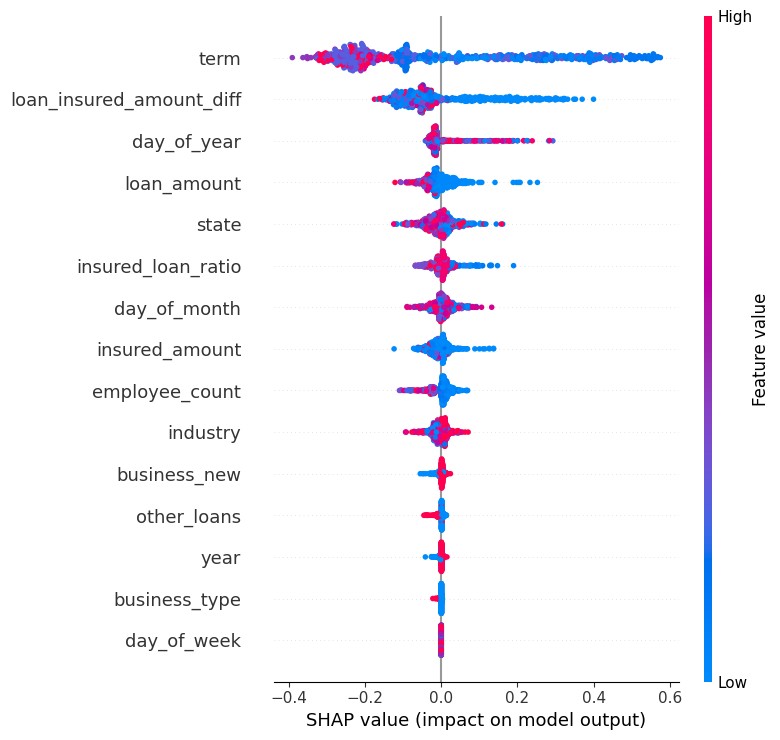

In [104]:
shap.summary_plot(shap_values, val_subset[features])

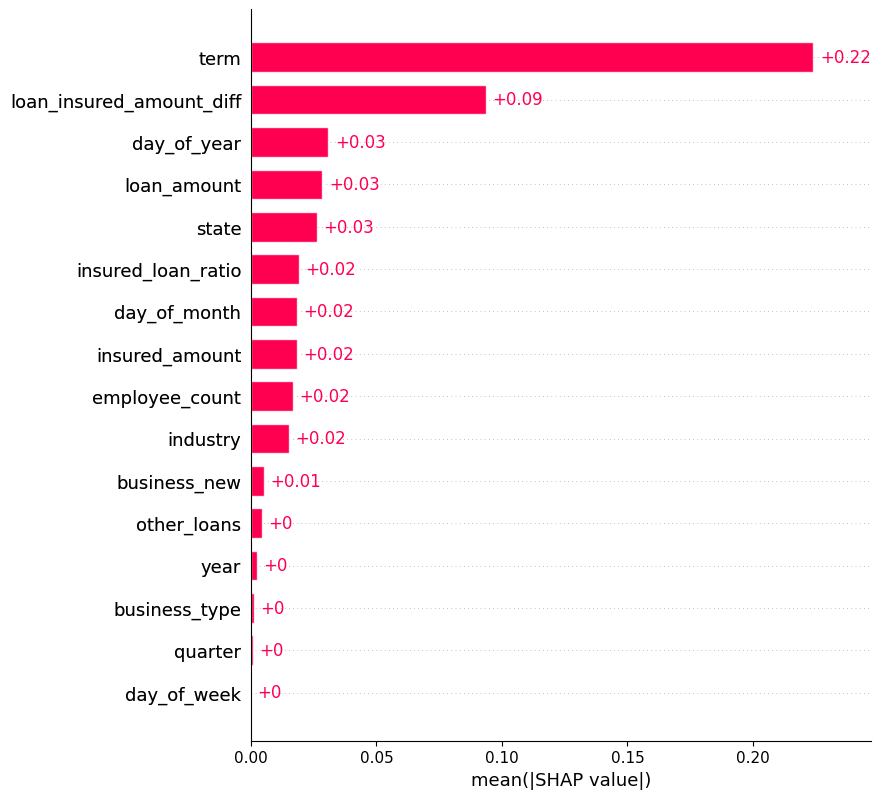

In [125]:
shap.plots.bar(shap_values, max_display = 17)

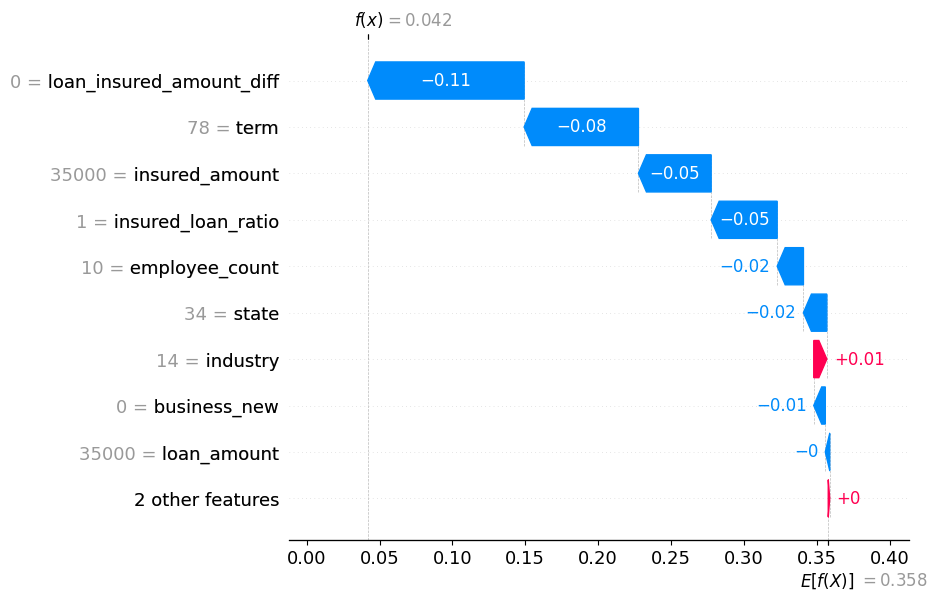

In [87]:
shap.plots.waterfall(shap_values[0])

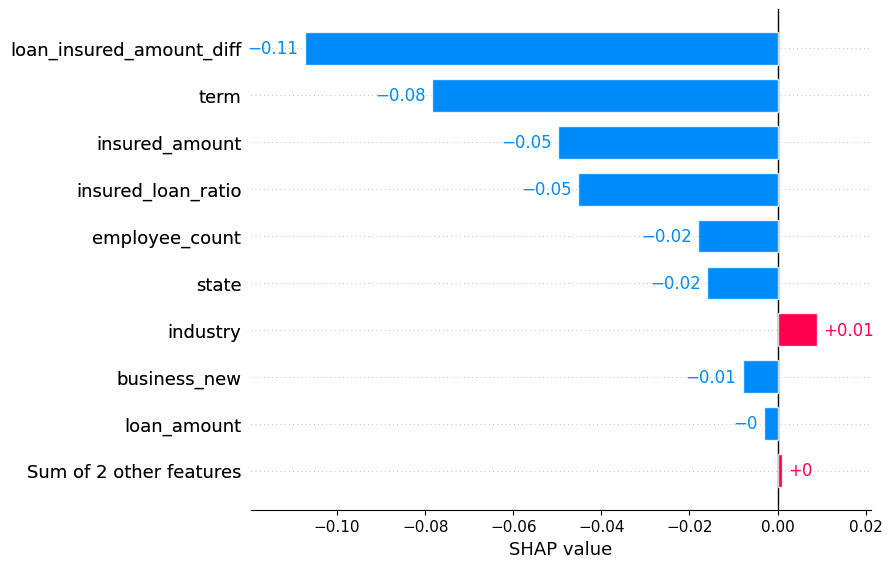

In [88]:
shap.plots.bar(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


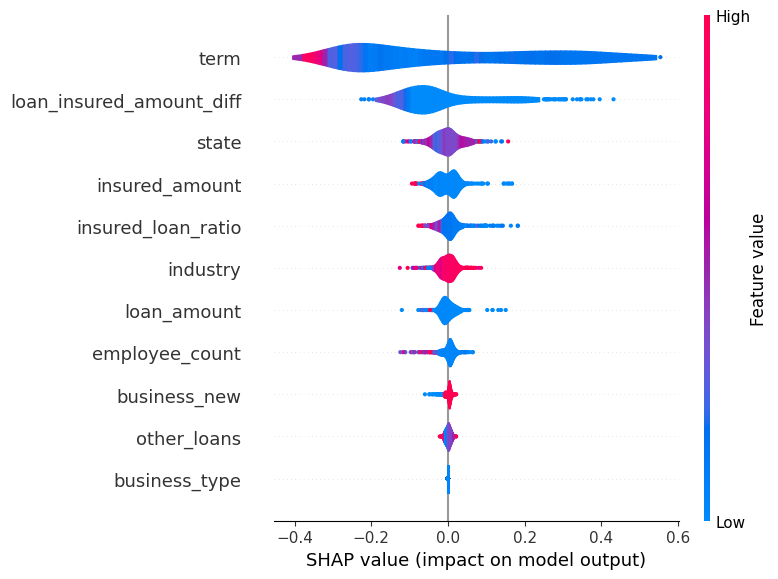

In [89]:
shap.summary_plot(shap_values, plot_type='violin')

In [ ]:
# TODO:
# 15) Use SHAP values to explain the contribution of each feature on the predictions (train/test dataset) + generate feature importance
# 21) A presentation to share your findings and takeaways to your non-technical business stakeholders to convince them that your approach is correct, effective, and deployable. 